In [21]:
import dolfinx
import ufl
import petsc4py
import mpi4py
import meshio
import h5py
import matplotlib
import pyvista
print("All core packages import successfully.")


All core packages import successfully.


In [22]:
import os, sys
from pathlib import Path

ROOT = Path.home() / "Documents" / "trap_sim"
os.chdir(ROOT)                       # so relative paths work
sys.path.insert(0, str(ROOT))        # so "from src..." works

print("CWD:", Path.cwd())
print("ROOT:", ROOT)


CWD: /Users/michaelee408/Documents/trap_sim
ROOT: /Users/michaelee408/Documents/trap_sim


In [23]:
from src.toy_geometry import generate_strip_trap_2d

generate_strip_trap_2d(
    filename="meshes/toy/strip_2d.msh",
    width=200e-6,
    height=200e-6,
    rf_width=80e-6,
    gap=20e-6,
    mesh_size=8e-6
)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000204708s, CPU 0.00039s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00667279s, CPU 0.010978s)
Info    : 794 nodes 1593 elements
Info    : Writing 'meshes/toy/strip_2d.msh'...
Info    : Done writing 'meshes/toy/strip_2d.msh'
Mesh written to meshes/toy/strip_2d.msh


In [24]:
import meshio
import numpy as np
from pathlib import Path

msh_path = ROOT / "meshes/toy/strip_2d.msh"
out_dir = ROOT / "meshes/toy/strip_2d_xdmf"
out_dir.mkdir(parents=True, exist_ok=True)

msh = meshio.read(msh_path)

def collect_cells_and_tags(cell_type: str):
    """Concatenate cells + gmsh:physical tags across all blocks of a given type."""
    cells_list = []
    tags_list = []
    has_phys = "gmsh:physical" in msh.cell_data

    for i, block in enumerate(msh.cells):
        if block.type == cell_type:
            cells_list.append(block.data)
            if not has_phys:
                raise ValueError("No 'gmsh:physical' cell_data found in the .msh file.")
            tags_list.append(np.asarray(msh.cell_data["gmsh:physical"][i], dtype=np.int32))

    if len(cells_list) == 0:
        raise ValueError(f"No cells of type '{cell_type}' found in the .msh file.")

    cells = np.vstack(cells_list)
    tags = np.concatenate(tags_list)

    if len(tags) != len(cells):
        raise ValueError(
            f"Tag length mismatch for '{cell_type}': tags={len(tags)} vs cells={len(cells)}. "
            "This usually means missing/incorrect Physical Groups."
        )
    return cells, tags

# 2D: triangles are domain, lines are boundary facets
tri_cells, tri_tags = collect_cells_and_tags("triangle")
line_cells, line_tags = collect_cells_and_tags("line")

meshio.write(
    out_dir / "mesh.xdmf",
    meshio.Mesh(
        points=msh.points,
        cells=[("triangle", tri_cells)],
        cell_data={"name_to_read": [tri_tags]},
    ),
)

meshio.write(
    out_dir / "facets.xdmf",
    meshio.Mesh(
        points=msh.points,
        cells=[("line", line_cells)],
        cell_data={"name_to_read": [line_tags]},
    ),
)

print("Wrote:", out_dir / "mesh.xdmf")
print("Wrote:", out_dir / "facets.xdmf")
print("Triangles:", len(tri_cells), "Lines:", len(line_cells))



Wrote: /Users/michaelee408/Documents/trap_sim/meshes/toy/strip_2d_xdmf/mesh.xdmf
Wrote: /Users/michaelee408/Documents/trap_sim/meshes/toy/strip_2d_xdmf/facets.xdmf
Triangles: 1485 Lines: 101


In [25]:
from mpi4py import MPI
from dolfinx import io
from src.mesh_io import load_xdmf, print_mesh_report

md = load_xdmf(str(out_dir / "mesh.xdmf"), mesh_name="Grid")

with io.XDMFFile(MPI.COMM_WORLD, str(out_dir / "facets.xdmf"), "r") as xdmf:
    facet_tags = xdmf.read_meshtags(md.domain, name="Grid")

md.facet_tags = facet_tags
print_mesh_report(md)


=== Mesh report ===
gdim: 3, tdim: 2
local vertices: 794, local cells: 1485
cell tags present: None
facet tags present: [1, 10]
facet tag counts: {1: 91, 10: 10}


In [26]:
from src.laplace import solve_laplace_tagged, export_xdmf

RF_TAG, GND_TAG = 10, 1

res = solve_laplace_tagged(
    md.domain,
    md.facet_tags,
    {RF_TAG: 1.0, GND_TAG: 0.0},
    degree=1,
    petsc_options_prefix="toy_laplace_",
    petsc_options={"ksp_type": "cg", "pc_type": "jacobi"}
)

phi = res.phi
print("Solved Laplace. phi dofs:", phi.x.array.size)

# Export phi for inspection (ParaView / PyVista)
(ROOT / "outputs/toy").mkdir(parents=True, exist_ok=True)
export_xdmf(md.domain, (phi,), "outputs/toy/phi_basis.xdmf")
print("Exported: outputs/toy/phi_basis.xdmf")


Solved Laplace. phi dofs: 794
Exported: outputs/toy/phi_basis.xdmf


In [27]:
import numpy as np
from dataclasses import dataclass

@dataclass
class TrapMinimum:
    r_min: np.ndarray
    psi_min: float
    local_index: int

def find_minimum_cg1(Psi):
    vals = Psi.x.array.real
    local_idx = int(np.argmin(vals))
    local_min = float(vals[local_idx])
    r_local = Psi.function_space.mesh.geometry.x[local_idx, :].copy()
    return TrapMinimum(r_min=r_local, psi_min=local_min, local_index=local_idx)


In [30]:
import numpy as np
from src.metrics import (
    compute_rf_pseudopotential,
    find_minimum_cg1,
    secular_frequencies_from_pseudopotential,
    estimate_trap_depth_by_rays,
    line_cut
)

# Physical constants / example trap params
q = 1.602176634e-19          # Coulomb (single charge)
m = 171 * 1.660539066e-27    # kg (Yb+ example; replace later)
Omega = 2*np.pi*40e6         # rad/s (40 MHz example; replace later)
Vrf = 80.0                   # volts (example; replace later)

Psi = compute_rf_pseudopotential(
    phi, q_coulomb=q, m_kg=m, Omega_rad_s=Omega, Vrf_volts=Vrf,
    degree=1,
    prefix="toy_Psi_",
    petsc_options={"ksp_type": "cg", "pc_type": "jacobi"}
)

# Export Psi
export_xdmf(md.domain, (Psi,), "outputs/toy/Psi_RF_J.xdmf")
print("Exported: outputs/toy/Psi_RF_J.xdmf")

# Find minimum (approx, CG1)
mininfo = find_minimum_cg1(Psi)
print("Trap min r (m):", mininfo.r_min)
print("Psi_min (J):", mininfo.psi_min)

# Secular frequencies from Hessian near min (choose h based on mesh_size)
sec = secular_frequencies_from_pseudopotential(Psi, m_kg=m, r0=mininfo.r_min, h=3e-6)
print("Secular freqs (Hz):", sec.freq_hz)
print("Secular freqs (MHz):", sec.freq_hz / 1e6)

# Depth estimate by rays (2D here, so ±x, ±y)
depth = estimate_trap_depth_by_rays(Psi, mininfo.r_min, r_max=120e-6, n=250)
print("Trap depth (eV):", depth.depth_ev)
print("Worst dir:", depth.worst_direction, "samples:", depth.ray_samples_used)


Exported: outputs/toy/Psi_RF_J.xdmf


Exception: Invalid MPI_Op, error stack:
internal_Allreduce_c(347)...: MPI_Allreduce_c(sendbuf=0x60000175a8c0, recvbuf=0x600001760100, count=3, MPI_DOUBLE, MPI_MINLOC, MPI_COMM_WORLD) failed
MPIR_MINLOC_check_dtype(145): MPI_Op MPI_MINLOC operation not defined for this datatype 

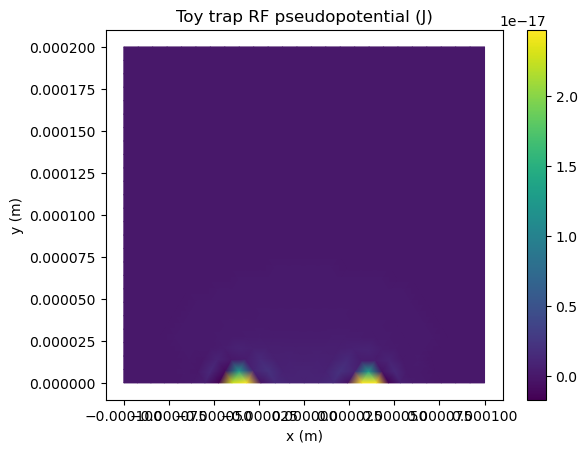

NameError: name 'mininfo' is not defined

In [29]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

domain = md.domain

domain.topology.create_connectivity(2, 0)
cells = domain.topology.connectivity(2, 0).array.reshape(-1, 3)

x = domain.geometry.x[:, 0]
y = domain.geometry.x[:, 1]
tri = mtri.Triangulation(x, y, triangles=cells)

plt.figure()
tpc = plt.tripcolor(tri, Psi.x.array.real, shading="gouraud")
plt.colorbar(tpc)
plt.title("Toy trap RF pseudopotential (J)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

# Line cut through minimum along +y (vertical)
lc = line_cut(Psi, mininfo.r_min, direction=np.array([0.0, 1.0]), t_min=-30e-6, t_max=120e-6, n=200)

plt.figure()
plt.plot(lc.t * 1e6, lc.values / 1.602176634e-19)  # eV
plt.xlabel("t along +y (um)")
plt.ylabel("Psi (eV)")
plt.title("Line cut through trap min")
plt.grid(True)
plt.show()
